# Generate Input - MIMS

This script will read in the raw .xlh MIMS files and calculate the 30 sec average. It also prefilters the raw data to remove outliers.

In [83]:
## Install the package if needed:
#install.packages('Mcomp', repos='http://cran.us.r-project.org')

## Load the relevent packages
#library(ncdf4)  # For reading in the NCEP wind fields
#library(R.matlab)  # If you need to read in matlab .mat files
library(openxlsx)  # If you need to read in .xlsx files
#library(rNOMADS)  # For reading grib2 data files (NOMADS data for instance)
#library(rGDAL)  #
library(RColorBrewer)
library(compiler)  # required for JIT (below)

## Enable compilation (speed gain?)
enableJIT(3)

## Helper function for converting the date time stamps.
conv_excel_time = function(x, tz='US/Pacific') {
    as.POSIXct(as.Date(x, origin="1899-12-30", tz=tz))
}

get.qual.pal = function(n=100, pal='Accent') {
    colorRampPalette(brewer.pal(8, pal))(n)
}

get.seq.pal = function(n=100, pal='YlOrRd') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

get.div.pal = function(n=100, pal='Spectral') {
    colorRampPalette(rev(brewer.pal(11, pal)))(n)
}

make.div.pal = function(x=100, n, pal='Spectral') {
    get.div.pal(n, pal=pal)[as.numeric(cut(x, breaks = n))]
}

[1] 3

In [84]:
processFile = function(filepath) {
  con = file(filepath, "r")
    i = 0
    
    dat = data.frame(cycle = 0, time = 0, X18 = 0, X28 = 0, X32 = 0, X40 = 0, X44 = 0, 
                      X45 = 0, TP = 0, N2.Ar = 0, O2.Ar = 0, N2.O2 = 0, BK.v = 0, BK.a = 0, BK.w = 0)
    
  while ( TRUE ) {
    i = i + 1
    line = readLines(con, n = 1)
    if ( length(line) == 0 ) {
      break
    }
    if (i > 9) {
        if (nchar(line) > 5) {
            s = strsplit(line, split = '\t')[[1]]
            if (length(s) == 15) {
                dat[nrow(dat)+1,] =  as.numeric(s)
            }
            
        }
        
        }
    }
    dat$time = conv_excel_time(dat$time)
    dat = take.avg(dat)
    close(con)
    return(dat)
}

#### take.avg
##
## This Function accepts a data.frame (x) and returns a 30 second averaged output.
## It assumes only columns 3 and up should be averaged (e.g. column 2 is time). It
## Also removes gross outliers (O2/Ar ratios over 40 and less than 10).

take.avg = function(x) {
    x = x[which(x$O2.Ar > 10 & x$O2.Ar < 40),]
    i = 1
    while (i < nrow(x)) {
        dt = as.numeric(difftime(x$time[1], x$time, units = 'sec'))
        l = which(dt > dt[i] & dt - dt[i] <= 30)
        temp = apply(x[l,3:ncol(x)], 2, function(x) {mean(x, na.rm = TRUE)})
        x[i,3:ncol(x)] = temp
        l = l[l != i]
        if (length(l) > 1) {
            x = x[-l,]
        }
        i = i + 1
    }
    x
}

In [49]:
input.dir = 'Raw data/MIMS/'

## Generate list of files in the directory
file.list = list.files(input.dir)

## split file.list into usable lists
file.list = file.list[grepl('.xlh', file.list)]
length(file.list)

[1] 79

In [50]:
data = processFile(paste0(input.dir, file.list[1]))
i = 1
while (TRUE) {
    gc()
    data = rbind(data, processFile(paste0(input.dir, file.list[i+1])))
    i = i + 1
    
    data = write.summary(data)
    if (i > length(file.list)) {
        break
    }
} 

Warning message in file(filepath, "r"):
"cannot open file 'Raw data/MIMS/NA': No such file or directory"

ERROR: Error in file(filepath, "r"): cannot open the connection


## Save

In [52]:
save(data, file='RStates/MIMS-Preliminary.rdata')

write.xlsx(data, 'Input Data/MIMS-Preliminary.xlsx')

In [93]:
nrow(data)

[1] 79729

In [95]:
write.xlsx(data[c(30000:32000),], 'Input Data/MIMS-Sample2.xlsx')

In [86]:
setwd('/Volumes/Repository/Dropbox/CCE-shipdata/MIMS-TBK/')
load(file='RStates/MIMS-Preliminary.rdata')

---
## Visualize Data

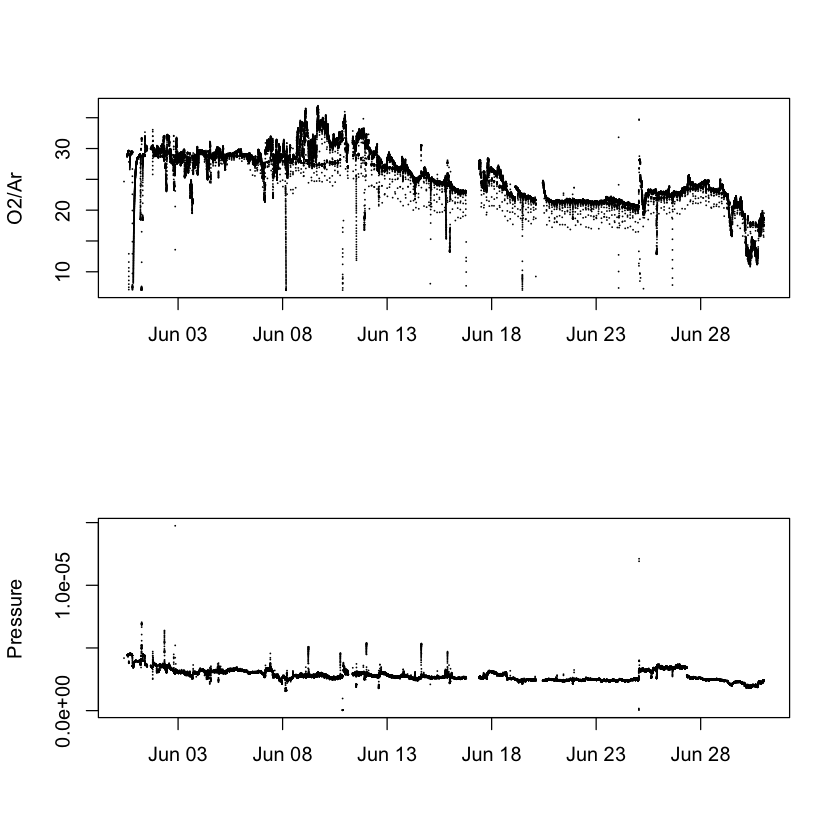

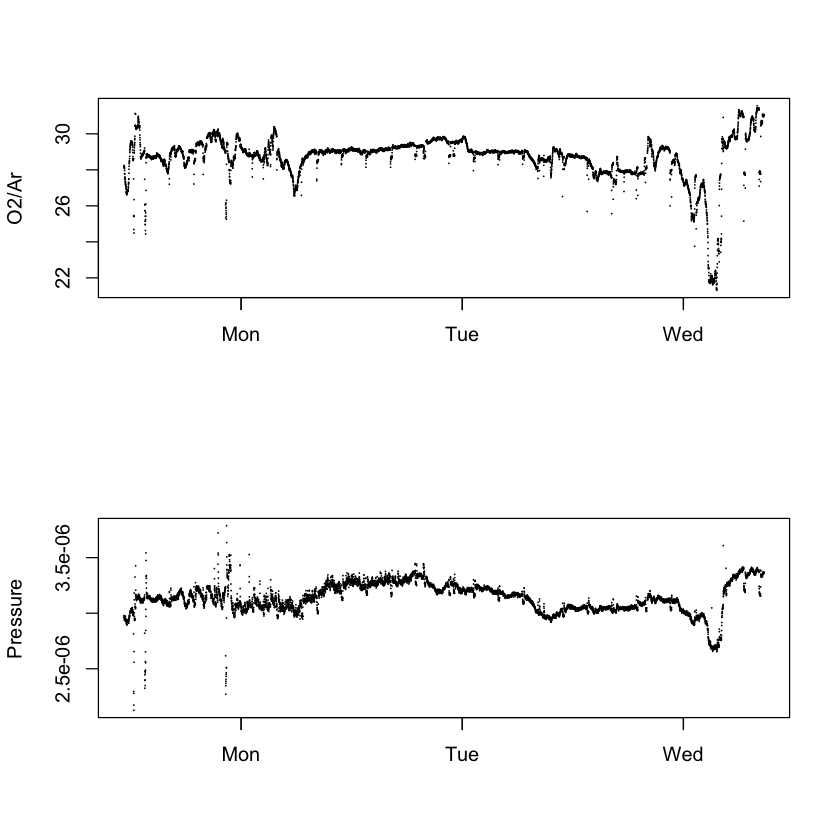

In [87]:
#pdf('Output/MIMS-Overview.pdf')

par(mfrow=c(2,1))
plot(data$time, data$O2.Ar, pch=16, cex=0.2, ylab='O2/Ar', xlab='')
plot(data$time, data$TP, pch=16, cex=0.2, ylab='Pressure', xlab='')

l = c(1000:1800)
plot(data$time[l], data$O2.Ar[l], pch=16, cex=0.2, ylab='O2/Ar', xlab='')
plot(data$time[l], data$TP[l], pch=16, cex=0.2, ylab='Pressure', xlab='')

#dev.off()

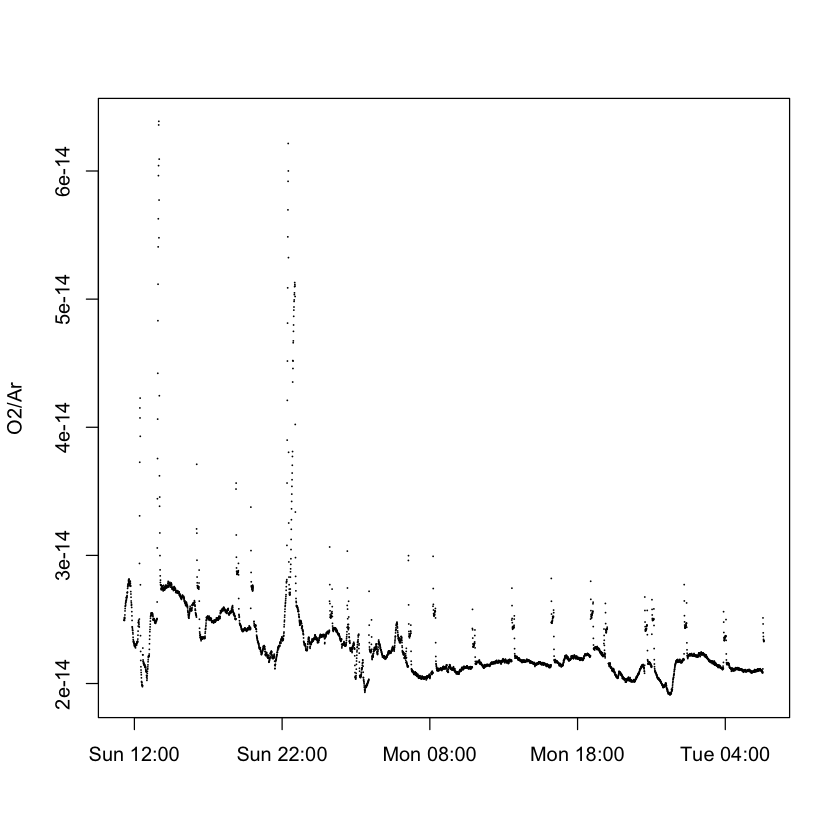

In [110]:

plot(data$time[c(10000:15000)], data$X44[c(10000:15000)] * data$X18[c(10000:15000)] * 1000, pch=16, cex=0.2, ylab='O2/Ar', xlab='')


In [2]:
nrow(data)

[1] 79729